<a href="https://colab.research.google.com/github/3aLaee/VDS2425-Project/blob/Muhammad/VD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import zipfile
import os
import pandas as pd

# === Unzip the file ===
zip_path = "/content/drive/MyDrive/VDS2425 Football.zip"
extract_dir = "/content/data/VDS2425_Football"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# === Load required CSVs ===
match_df = pd.read_csv(f"{extract_dir}/Match.csv", low_memory=False)
team_attr_df = pd.read_csv(f"{extract_dir}/Team_Attributes.csv")


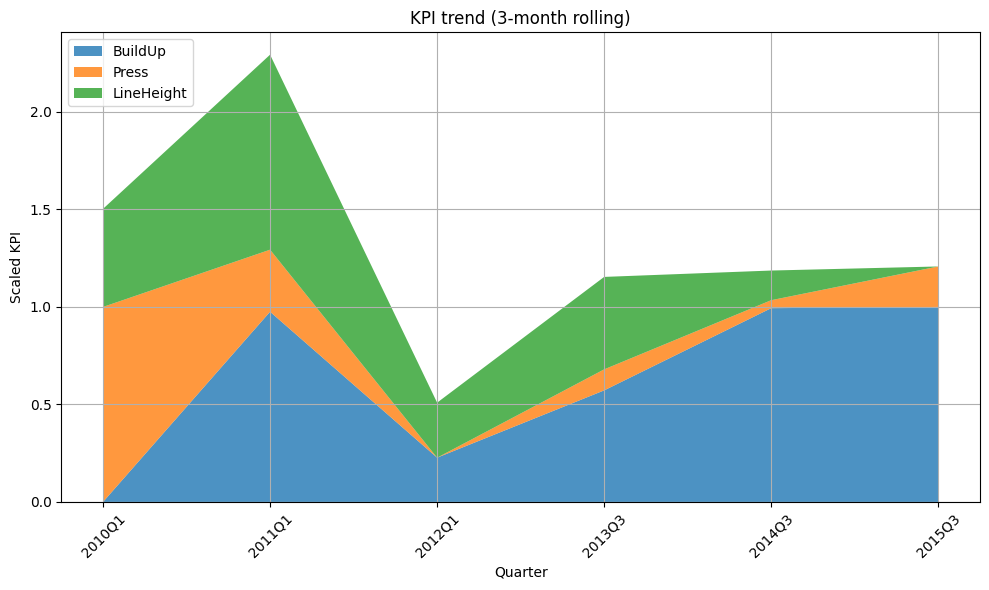

In [14]:
import matplotlib.pyplot as plt

# === Prepare KPI trend data ===
team_attr_df['date'] = pd.to_datetime(team_attr_df['date'])
team_attr_df['Quarter'] = team_attr_df['date'].dt.to_period('Q')

kpi_df = team_attr_df.groupby('Quarter')[['buildUpPlaySpeed', 'defencePressure', 'defenceTeamWidth']].mean().reset_index()
kpi_df.columns = ['Quarter', 'BuildUp', 'Press', 'LineHeight']

# Normalize
kpi_df[['BuildUp', 'Press', 'LineHeight']] = kpi_df[['BuildUp', 'Press', 'LineHeight']].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.stackplot(kpi_df['Quarter'].astype(str), kpi_df['BuildUp'], kpi_df['Press'], kpi_df['LineHeight'],
              labels=['BuildUp', 'Press', 'LineHeight'], alpha=0.8)
plt.legend(loc='upper left')
plt.title('KPI trend (3-month rolling)')
plt.xlabel('Quarter')
plt.ylabel('Scaled KPI')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-15-b12989d73a43>:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  match_df['date'] = pd.to_datetime(match_df['date'], errors='coerce')
<ipython-input-15-b12989d73a43>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['xG_conceded'] = np.random.choice([0.5, 1.0, 1.5], size=len(filtered))


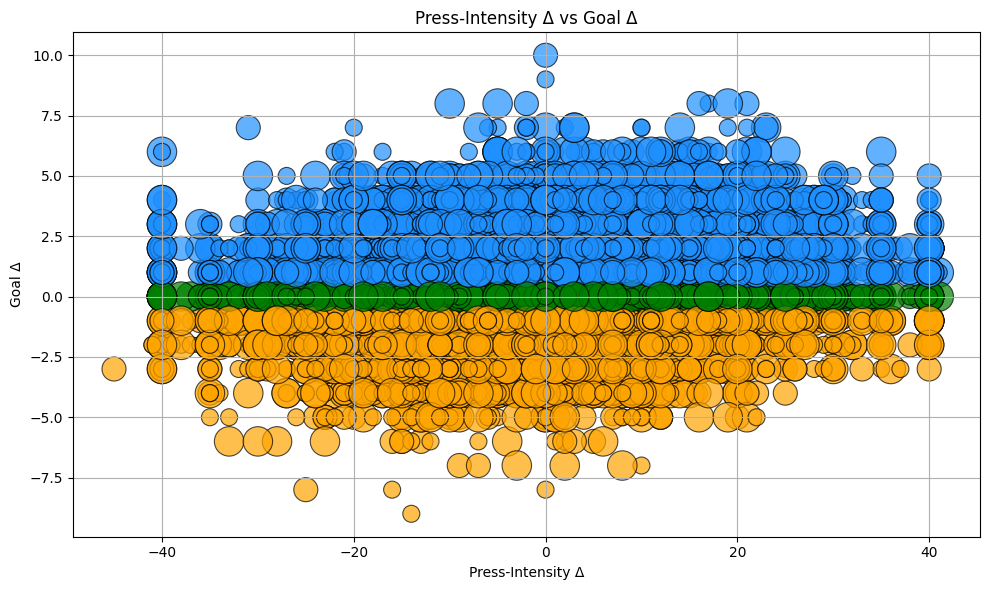

In [15]:
import numpy as np

# === Prepare match data ===
match_df['date'] = pd.to_datetime(match_df['date'], errors='coerce')
match_df['goal_delta'] = match_df['home_team_goal'] - match_df['away_team_goal']

# Merge team press values
team_press = team_attr_df[['team_api_id', 'date', 'defencePressure']].sort_values(['team_api_id', 'date'])

def get_latest_press(team_id, match_date):
    history = team_press[(team_press['team_api_id'] == team_id) & (team_press['date'] <= match_date)]
    return history['defencePressure'].iloc[-1] if not history.empty else None

match_df['home_press'] = match_df.apply(lambda row: get_latest_press(row['home_team_api_id'], row['date']), axis=1)
match_df['away_press'] = match_df.apply(lambda row: get_latest_press(row['away_team_api_id'], row['date']), axis=1)
match_df['press_delta'] = match_df['home_press'] - match_df['away_press']

# Result label
def result_label(gd):
    return 'Win' if gd > 0 else 'Draw' if gd == 0 else 'Loss'

match_df['result'] = match_df['goal_delta'].apply(result_label)
filtered = match_df.dropna(subset=['press_delta', 'goal_delta'])

# Dummy xG_conceded values
np.random.seed(42)
filtered['xG_conceded'] = np.random.choice([0.5, 1.0, 1.5], size=len(filtered))

# Color mapping
color_map = {'Win': 'dodgerblue', 'Draw': 'green', 'Loss': 'orange'}
colors = filtered['result'].map(color_map)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.scatter(filtered['press_delta'], filtered['goal_delta'],
            s=filtered['xG_conceded'] * 300,
            c=colors, alpha=0.7, edgecolors='k', linewidth=0.8)

plt.title('Press-Intensity Δ vs Goal Δ')
plt.xlabel('Press-Intensity Δ')
plt.ylabel('Goal Δ')
plt.grid(True)
plt.tight_layout()
plt.show()
